In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
from PIL import Image

from keras.models import load_model


# ResNetModel = load_model('ResNetModel.h5')

# DenseNetModel = load_model('DenseNetModel.h5')

In [2]:
#preprocessing
def get_img(path):
    img = Image.open(path)
    img = np.array(img)
    print(img.shape)
    H,W,D = img.shape
    
    video = np.zeros((2, H, W, D), dtype = np.float32)
    video[0] = img
    return video

def prepro(video) :
    
    resize_video = np.zeros((len(video), 256, 256, 1), dtype = np.float32)

    for i, img in enumerate(video):
        resize_video[i] = resize(img, output_shape=(256, 256, 1), preserve_range=True)
        
    max_num = 0
    for j, image in enumerate(resize_video) :
        max_num = np.max(image)
        
        if(np.abs(image.min()) > max_num) :
            max_num = np.abs(image.min())
            
        if(max_num != 0) :
            image = image / max_num
        
        if(np.min(image) < 0) :
            image = image + 1
            image = image / 2
        
        resize_video[j] = image
#         print('Number : ', j ,' min :', resize_video[j].min(),'max : ' ,resize_video[j].max())
    return resize_video

In [3]:
#폐영역 분할
def Image_Segmentation(video):
    
    ImageSegmentationModel = load_model('Image_Segmentation_Model.h5')
    predicts = ImageSegmentationModel.predict(video)
    predict = predicts[...,0]
    
    copy_video = video.copy()
    copy_video[predict < 0.5] = 0
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 100))
    
    ax[0].imshow(video[0], cmap = 'gray')
    ax[1].imshow(copy_video[0], cmap = 'gray')
    
    
    return copy_video

In [4]:
#감염된 영역 탐색
def Detection(Image_Segmentation, video): #segmentation
    DetectInfectionModel = load_model('Detect_Infection.h5')
    predicts = DetectInfectionModel.predict(Image_Segmentation)
    predict = predicts[...,0]
    
    predict[predict >= 0.5] = 1
    predict[predict < 0.5] = 0
    
    point = np.where(predict[0] == 1)
    
    color_segmentation = resize(Image_Segmentation[0], output_shape=(256,256,3), preserve_range = True)
    color_video = resize(video[0], output_shape=(256,256,3), preserve_range = True)
    
    
    for j, x in enumerate(point[0]) :
        color_segmentation[x][point[1][j]] = (0.5,0,0)
        color_video[x][point[1][j]] = (0.5,0,0)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 100))
    
    ax[0].imshow(Image_Segmentation[0], cmap = 'gray')
    ax[1].imshow(color_segmentation)
    
    
    return color_segmentation, color_video

In [5]:
#Sverity 표시
def Severity(video, color_segmentation):
    img = resize(video[0], (1,128,128,3))
    img_color_segmentation = resize(color_segmentation, (128,128,3))
    ResNetModel = load_model('ResNetModel.h5')
    predict = ResNetModel.predict(img)
    ct_labels=["CT-0", "CT-1", "CT-2", "CT-3", "CT-4"]
    print("Severity :{}".format(ct_labels[np.argmax(predict[0])]))
    
    plt.imshow(img_color_segmentation)
    
    return ct_labels[np.argmax(predict[0])]

In [6]:
#COVID-19 and 폐렴 진단
def Covid_and_pneomonia(video, color_video,severity):
    img = resize(video[0], (1,128,128,3))
    img_color_video = resize(color_video, (128,128,3))
    
    DenseNetModel = load_model('DenseNetModel.h5')
    predict = DenseNetModel.predict(img)
    
    disease_labels=["Non-Covid-19", "Covid-19"]
    
    print("Label :{}".format(disease_labels[np.argmax(predict[0])]))
    print("Severity :{}".format(severity))
    plt.imshow(img_color_video)
    

(512, 512, 3)


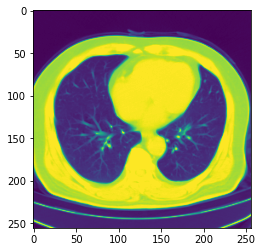

In [7]:
imgs = get_img("non-Covid_example.jpg")
video = prepro(imgs)
plt.imshow(video[0])

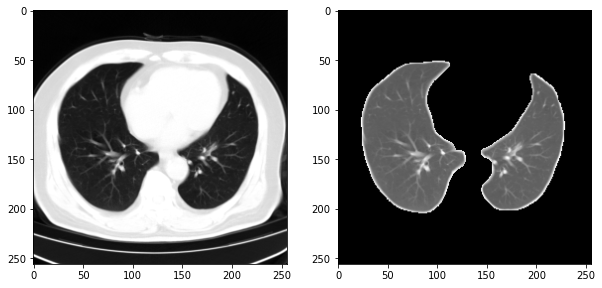

In [8]:
Image_Segmentation = Image_Segmentation(video)

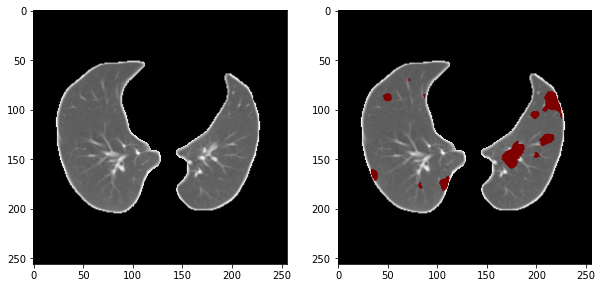

In [9]:
color_segmentation, color_video = Detection(Image_Segmentation, video)

Severity :CT-2


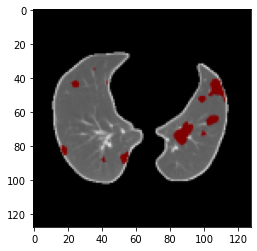

In [10]:
severity = Severity(video, color_segmentation)

Label :Non-Covid-19
Severity :CT-2


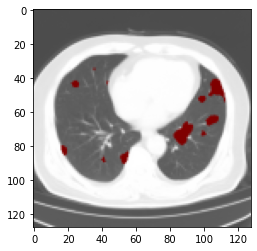

In [11]:
Covid_and_pneomonia(video,color_video,severity)